In [0]:
%%capture
!pip install numpy
!pip install pandas==0.23.4
!pip install matplotlib
!pip install seaborn==0.9.0
!pip install beautifulsoup4
!pip install langid
!pip install shap
!pip install xgboost
!pip install sklearn
!pip install spacy
!pip install xlrd

In [0]:
%%capture
import spacy.cli
#downloading language model for text processing
spacy.cli.download("en_core_web_md")

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from bs4 import BeautifulSoup as BSHTML
import re 
import langid
import spacy
import xgboost as xgb

pd.set_option('display.max_colwidth', -1)

<h3>Input function</h3>

<p>First let&#39;s create an input function to summarise the findings in the EDA notebooks</p>


In [0]:
def INPUT_FUNC(url):
    '''This function takes care of inputting data and some transformation as described in the end of EDA notebook'''
    #Input data
    data = pd.read_excel(url,index_col='TweetID')
    
    #Transforming dates
    data['TweetPostedTime'] = pd.to_datetime(data['TweetPostedTime'],utc=True)
    data['UserSignupDate'] = pd.to_datetime(data['UserSignupDate'], utc=True)
    
    #Calculate user active days
    data['UserAccTime'] = (max(data.TweetPostedTime) - data.UserSignupDate).dt.days
    
    
    #Remove rows of Lonely Planet
    data = data[data.UserName != 'Lonely Planet']
    
    #Calculating tweet hour
    data['TweetHour'] = data.TweetPostedTime.dt.hour
    
    #Calculating tweet recency
    data['TweetRecency'] = ((max(data.TweetPostedTime) - data.TweetPostedTime).dt.seconds)/60
    
    #Create some new columns
    pattern = r'(RT @[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)'
    
    data['TweetProcessed'] = 'a'
    data['TweetLength']=0
    data['TweetLang']='a'
    data['TweetSrcProcessed'] = 'a'
    
    for row in data.itertuples():
        #Light processing on Tweet body
        data.set_value(row.Index, 'TweetProcessed', ' '.join(re.sub(pattern, ' ', row.TweetBody).split()))
        #Tweet Length
        data.set_value(row.Index, 'TweetLength', len(row.TweetProcessed))
        #Identify language
        data.set_value(row.Index, 'TweetLang', langid.classify(row.TweetProcessed)[0])
        #Removing html tags
        data.set_value(row.Index, 'TweetSrcProcessed', BSHTML(row.TweetSource, 'html.parser').get_text())
    
    data.TweetSrcProcessed = data.TweetSrcProcessed.astype('category')
    
    #Filtering rows that is not English
    data = data[data['TweetLang']=='en']
    
    #Vectorising texts
    nlp = spacy.load('en_core_web_md', disable=['ner','tagger'])
    TweetLemma = []
    
    for doc in nlp.pipe(data.TweetProcessed, batch_size=1000):
        tokens = ([token.lemma_.strip() for token in doc if 
            ((token.is_punct == False) and (token.is_stop == False) 
             and (token.like_num == False) and (token.is_digit == False) 
                and (token.lemma_ != '-PRON-'))])
        
        processed_c = ' '.join(tokens)
        TweetLemma.append(processed_c)
    
    data['TweetTokenized'] = TweetLemma
    
    #We have to loop second time because the first time the text wasnt processed
    embeddings = []
    for doc in nlp.pipe(data.TweetTokenized, batch_size=1000):
        #This is a 300 dim vector representing the tweet body by averaging vector 
        #values of individual tokens. The token embedding model come pretrained by spacy
        embeddings.append(doc.vector)
    body_embeddings_df = pd.DataFrame(embeddings)
    
    for i in range(len(embeddings[0])):
        data.loc[:,'Vector'+ str(i)] = body_embeddings_df.iloc[:,i].values
        
    
    col_to_drop = ['TweetPlaceID', 'TweetPlaceName', 'TweetPlaceFullName','TweetCountry','TweetPlaceBoundingBox',
              'TweetPlaceAttributes', 'TweetPlaceContainedWithin', 'tweet.place',
               'TweetInReplyToStatusID', 'TweetInReplyToUserID', 'TweetInReplyToScreenName',
               'TweetProcessed','TweetLang' ,'TweetPostedTime', 'TweetTokenized', 'TweetBody', 
                'TweetSource', 'TweetHashtags',
                'UserLink', 'UserExpandedLink', 'UserLocation', 'UserScreenName','UserName', 'MacroIterationNumber',
               'UserID', 'UserDescription','UserSignupDate', ]
    df = data.drop(col_to_drop, axis=1).dropna()
    
    return df 

In [0]:
%%time
url = 'data.xlsx'
df = INPUT_FUNC(url)

CPU times: user 7min 40s, sys: 2min 35s, total: 10min 15s
Wall time: 5min 44s


In [0]:
df.to_csv('processed_data.csv', encoding = 'utf-8')

In [0]:
df_processed = pd.read_csv('processed_data.csv', index_col='TweetID')

<h3 id="Transformation">Transformation</h3>

<p>Next, some preprocessing is needed. Categorical columns need to be encoded while numerical columns need to be scaled. Since we have non-normal distributions in predictors, we should use a robust scaler.</p>

<p>The general training strategy is 10% holdout for evaluation while 90% used for training and cross validation.</p>


In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler

#Make sure data is shuffled
df_processed = shuffle(df_processed, random_state=42)

def TRANSFORM(df):
    cat_col = ['TweetSrcProcessed', 'TweetRetweetFlag']
    
    no_scale = ['TweetSrcProcessed', 'TweetRetweetFlag', 'TweetRetweetCount']
    num_col = df.columns.difference(no_scale)
    
    target = ['TweetRetweetCount']
    predictors = df.columns.difference(target)
    X = df.loc[:,predictors]
    y = df.loc[:,target]
    
    encoder = LabelEncoder()
    scaler = RobustScaler()
    
    X[cat_col] = X[cat_col].apply(encoder.fit_transform)
    X[num_col] = scaler.fit_transform(X[num_col])
    
    
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1, random_state=42)
    
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = TRANSFORM(df_processed)



<h3 id="Training">Training</h3>

<p>We will use xgb&nbsp;regressor as our model of choice mainly due to the odd distribution seen in both predictors and target variables. Moreover, xgb is well optimised compared to traditional ML models so our large feature space shouldn&#39;t be a problem.&nbsp;</p>

<p>We will also do some hyperparameter tuning via randomized search cv in sklearn.&nbsp;</p>


In [0]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals.joblib import parallel_backend

params_dist = {
    'max_depth':range(20,30,5),
    'min_child_weight':range(1,6,2),
    'gamma': [i/10.0 for i in range(0,5)],
    'colsample_bytree': np.linspace(0.1,0.5,5), 
    'subsample':np.linspace(0.2,0.9,5),
    'reg_alpha':[0.1, 1, 10,100],
    'learning_rate': np.linspace(0.1,0.3,3),
    'n_estimators': np.arange(50,150,50)
    }


def train_model(model, X, y,params_dist,cv_folds=5, n_iter_search=5):
    
    model_cv = RandomizedSearchCV(model,param_distributions=params_dist, return_train_score =True,
                                n_jobs =-1, scoring = 'neg_mean_absolute_error',
                                cv=cv_folds, n_iter=n_iter_search, random_state=42, verbose=6)
    with parallel_backend('threading'):
        model_cv.fit(X, y)
    
    return model_cv.best_params_

forest=xgb.XGBRegressor(objective='reg:linear', n_jobs=-1)

params = train_model(forest,X_train,y_train,params_dist=params_dist)
    

In [0]:
params

{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 20,
 'min_child_weight': 1,
 'n_estimators': 50,
 'reg_alpha': 0.1,
 'subsample': 0.9}

In [0]:
%%time

d_train = xgb.DMatrix(data=X_train, label=y_train.iloc[:,0].values, nthread=-1)
d_test = xgb.DMatrix(data=X_val, label=y_val.iloc[:,0].values,nthread=-1)

watch_list = {(d_test, 'eval'), (d_train, 'train')}

param_set = {'objective':'reg:linear','eval_metric':'mae',
            'max_depth':20, 'eta':0.3, 'n_estimators':50,
             'tree_method ':'gpu_exact',
             'gamma':0.0, 'reg_alpha':0.1,
             'subsample':0.9, 'colsample_bytree':0.4,
             'seed':0
              }

rounds = 50
eval_loss = {}

xgforestreg = xgb.train(params=param_set, dtrain=d_train,
                        evals=watch_list, num_boost_round=rounds, 
                       verbose_eval=True,
                       callbacks=[xgb.callback.record_evaluation(eval_loss)])

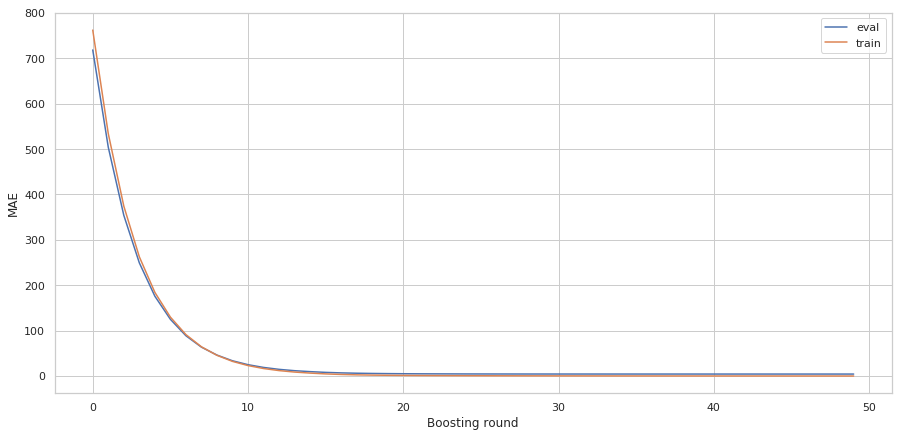

In [57]:
plt.figure(figsize=(15,7))
sns.lineplot(y=eval_loss['eval']['mae'], x=range(len(eval_loss['eval']['mae'])), label='eval')
sns.lineplot(y=eval_loss['train']['mae'], x=range(len(eval_loss['train']['mae'])), label='train')

plt.xlabel('Boosting round')
plt.ylabel('MAE')
plt.legend()
plt.show()

Pretty good fit with converging loss. There is no overfitting or underfitting.

In [30]:
from sklearn.metrics import mean_absolute_error
preds = xgforestreg.predict(d_test)
mae = mean_absolute_error(y_val,preds)
print('MAE: %f' % (mae))

MAE: 4.380329


In [31]:
eval_result = pd.DataFrame({'truth': y_val.iloc[:,0].values, 'prediction':preds})

eval_result['residuals'] = (eval_result['truth'] - eval_result['prediction'])
eval_result['absres'] = abs(eval_result['residuals'])
eval_result['absres'].describe()

count    4237.000000
mean     4.380329   
std      30.313320  
min      0.000000   
25%      0.004883   
50%      0.287945   
75%      1.726025   
max      980.010986 
Name: absres, dtype: float64

75% of our predictions has less than 2 units of error. Considering 50% of observations has less than 14 retweets, this is quite a good result.

Let's plot these residuals. 

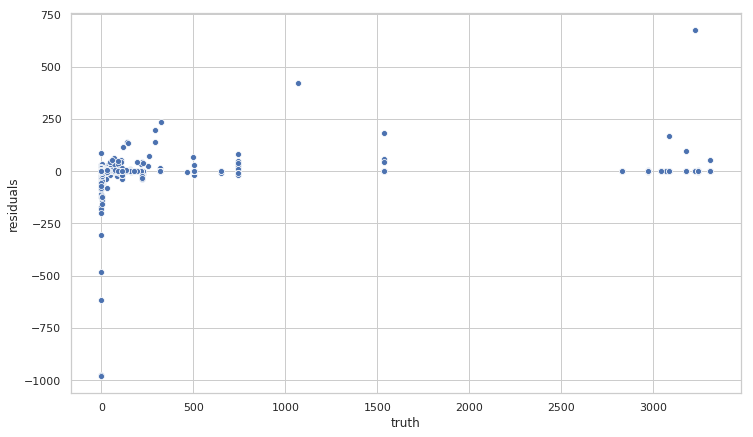

In [26]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,7))
sns.scatterplot(data=eval_result, x='truth',y='residuals')
plt.show()

We see there is no trend for residuals when plotted against ground truth. Plus there is only a handful of cases where the predictions error go too high. This is likely to be noise and can be ignored. 

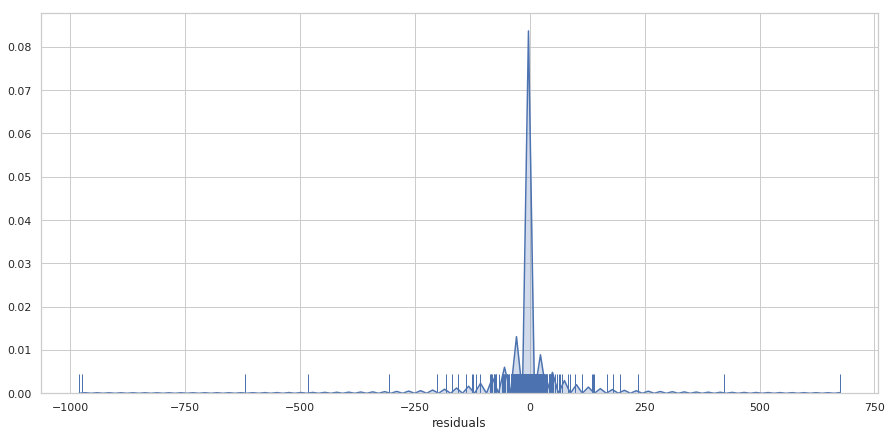

In [27]:
plt.figure(figsize=(15,7))
sns.distplot(eval_result['residuals'], rug=True, hist=False, kde_kws={'shade':True,'kernel':'gau'})

plt.show()

Most of our residuals center around 0. This seems good enough for the time being.

In [0]:
from sklearn.externals import joblib
file_name = 'base_forest_43.joblib.dat'

In [71]:
joblib.dump(xgforestreg, file_name)

['base_forest_43.joblib.dat']

In [0]:
loaded_model = joblib.load(file_name)

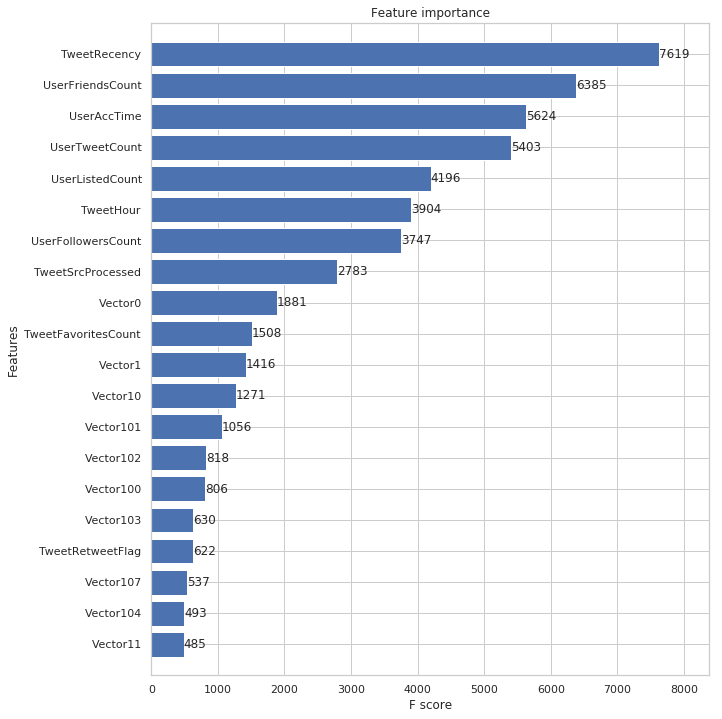

In [67]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(loaded_model, max_num_features=20, height=0.8, ax=ax, importance_type='weight')
#weight means number of splits on a var for all trees
plt.show()

Calculating by the number of splits, Tweet's recency seems to have the most effect, even more than the number of followers and followed. 

In [0]:
%%capture
import shap
target = ['TweetRetweetCount']
predictors = df_processed.columns.difference(target)

explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X_train, approximate=True)

<p>XGB feature importance function provides 3 options:&nbsp;</p>

<ul>
	<li>Weight: how often a feature is used to split across all trees</li>
	<li>Cover: Weight, weighted by the number of training observations go through each split</li>
	<li>Gain: Loss reduction when using a feature to split</li>
</ul>

<p>However, plotting with each kind of importance give different results. Moreover, when changes are made to a model such that it relies more on a feature, its importance should not change (consistency).&nbsp;</p>

<p>SHAP values solve these problems. Looking at our shap&nbsp;value feature importance below, most of the important features are related to the tweet body (starting with vector). Meaning that if you have a good content, it will be retweeted more.&nbsp;</p>


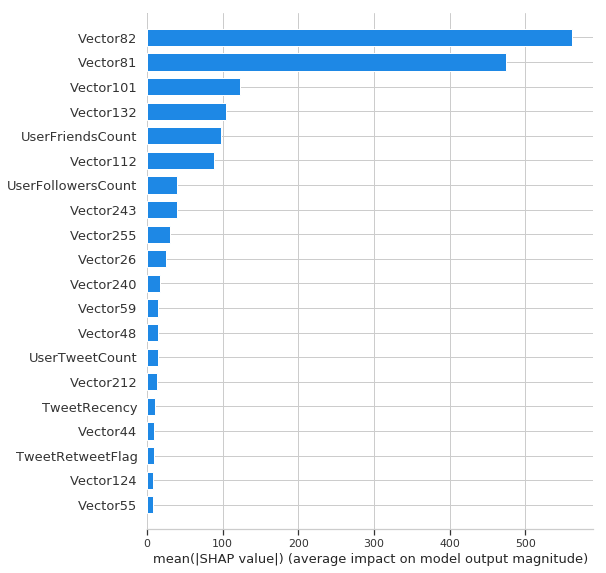

In [63]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

The nice thing about SHAP value is that it is intended to be individualised, so that one can always pull out an example and see which feature pushed the predicted value in which direction and by how much. In the below chart, for example, you see User Friends Count  actually negatively affects the predicted retweet amount.

In [69]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5,:], X_train.iloc[5,:])

<h2 id="Limitations">Limitations</h2>

<p>Models:&nbsp;</p>

<ul>
	<li>we could spend more time expanding the range for parameter search</li>
	<li>deep learning models can be developed with this model as baseline performance&nbsp;</li>
</ul>

<p>Features:&nbsp;</p>

<ul>
	<li>Frequency of tweet per user can be added i.e. 3rd tweet in the last 3 hours, 2nd tweet in the last hour, etc.&nbsp;</li>
	<li>If users tweet more, it would make sense to embed user id as well</li>
	<li>Custom document embeddings model can be trained to better embed the tweets body and also make use of the tags</li>
	<li>Sentiment analysis + topic modelling for each tweet would definitely help</li>
	<li>It is useful to get more info on the people that retweet/like the tweet as this generally lead to more retweets.&nbsp;</li>
</ul>

<p>General:&nbsp;</p>

<ul>
	<li>Hyperparameter tuning can be more efficiently done by using Bayesian optimisation via GCP (I&#39;m not sure AWS lambda offer the same)&nbsp;</li>
	<li>A lot of preprocessing can be done from API calls</li>
	<li>having more than one day data to train would be much better</li>
</ul>
